In [ ]:
# =============================================================================
# Multi-Class Classification on the Forest Cover Type Dataset with Logistic Regression
# =============================================================================
# This script demonstrates a full pipeline for predicting the cover type (7 classes)
# in a forest dataset from UCI. It includes:
# 1. Data loading from a CSV file ("forest_cover.csv").
# 2. Data preprocessing: handling missing values (if any), encoding categorical columns,
#    and scaling numeric columns.
# 3. Splitting the dataset into training (80%) and testing (20%) sets.
# 4. Training a LogisticRegression model (with a one-vs-rest approach by default).
# 5. Evaluating the model using a classification report, confusion matrix, and multi-class
#    ROC curve (macro-average).
# 6. Advanced visualizations:
#    - Parallel Coordinates Plot for multi-class data exploration.
#    - Confusion Matrix with a new colormap ("cubehelix").
#    - One-vs-Rest ROC curve for multi-class.
#    - PCA-based 2D scatter plot of test data color-coded by predicted class.
#    - Radar Chart for top 8 features from a permutation importance approach.
# =============================================================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.multiclass import OneVsRestClassifier
from sklearn.preprocessing import label_binarize
from sklearn.decomposition import PCA
from sklearn.inspection import permutation_importance


In [ ]:
# -----------------------------------------------------------------------------
# Set a distinctive visualization style: "dark_background"
# -----------------------------------------------------------------------------
plt.style.use("dark_background")
sns.set_theme(style="whitegrid", palette="deep")

In [ ]:
df = pd.read_csv("/content/covtype.csv")

In [ ]:
df.head()

,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,...,Soil_Type32,Soil_Type33,Soil_Type34,Soil_Type35,Soil_Type36,Soil_Type37,Soil_Type38,Soil_Type39,Soil_Type40,Cover_Type
0,2596,51,3,258,0,510,221,232,148,6279,...,0,0,0,0,0,0,0,0,0,5
1,2590,56,2,212,-6,390,220,235,151,6225,...,0,0,0,0,0,0,0,0,0,5
2,2804,139,9,268,65,3180,234,238,135,6121,...,0,0,0,0,0,0,0,0,0,2
3,2785,155,18,242,118,3090,238,238,122,6211,...,0,0,0,0,0,0,0,0,0,2
4,2595,45,2,153,-1,391,220,234,150,6172,...,0,0,0,0,0,0,0,0,0,5


In [ ]:
# ['Elevation','Aspect','Slope','Horizontal_Distance_To_Hydrology', ... , 'Cover_Type']
# 'Cover_Type' typically has 7 classes (1..7). We'll convert them to 0..6.

# Check for missing values
print("Missing values per column:\n", df.isna().sum())
# -----------------------------------------------------------------------------

Missing values per column:
 Elevation                             0
Aspect                                0
Slope                                 0
Horizontal_Distance_To_Hydrology      0
Vertical_Distance_To_Hydrology        0
Horizontal_Distance_To_Roadways       0
Hillshade_9am                         0
Hillshade_Noon                        0
Hillshade_3pm                         0
Horizontal_Distance_To_Fire_Points    0
Wilderness_Area1                      0
Wilderness_Area2                      0
Wilderness_Area3                      0
Wilderness_Area4                      0
Soil_Type1                            0
Soil_Type2                            0
Soil_Type3                            0
Soil_Type4                            0
Soil_Type5                            0
Soil_Type6                            0
Soil_Type7                            0
Soil_Type8                            0
Soil_Type9                            0
Soil_Type10                           0
Soil_Type11 

In [ ]:
# -----------------------------------------------------------------------------
# 2. Data Preprocessing
# -----------------------------------------------------------------------------
target = 'Cover_Type'
X = df.drop(target, axis=1)
y = df[target]

# Convert target from 1..7 to 0..6 for scikit-learn
y = y - 1  # So classes become 0..6

# Check if there are any categorical columns. Typically, forest cover data is numeric,
# but if there's a categorical col, we'd encode it:
cat_cols = X.select_dtypes(include=['object']).columns.tolist()
for col in cat_cols:
    X[col] = LabelEncoder().fit_transform(X[col].astype(str))

# Scale numeric features
num_cols = X.select_dtypes(include=['int64','float64']).columns.tolist()
scaler = StandardScaler()
X[num_cols] = scaler.fit_transform(X[num_cols])

print("Numeric columns:", num_cols)
print("Categorical columns:", cat_cols)
# -----------------------------------------------------------------------------

Numeric columns: ['Elevation', 'Aspect', 'Slope', 'Horizontal_Distance_To_Hydrology', 'Vertical_Distance_To_Hydrology', 'Horizontal_Distance_To_Roadways', 'Hillshade_9am', 'Hillshade_Noon', 'Hillshade_3pm', 'Horizontal_Distance_To_Fire_Points', 'Wilderness_Area1', 'Wilderness_Area2', 'Wilderness_Area3', 'Wilderness_Area4', 'Soil_Type1', 'Soil_Type2', 'Soil_Type3', 'Soil_Type4', 'Soil_Type5', 'Soil_Type6', 'Soil_Type7', 'Soil_Type8', 'Soil_Type9', 'Soil_Type10', 'Soil_Type11', 'Soil_Type12', 'Soil_Type13', 'Soil_Type14', 'Soil_Type15', 'Soil_Type16', 'Soil_Type17', 'Soil_Type18', 'Soil_Type19', 'Soil_Type20', 'Soil_Type21', 'Soil_Type22', 'Soil_Type23', 'Soil_Type24', 'Soil_Type25', 'Soil_Type26', 'Soil_Type27', 'Soil_Type28', 'Soil_Type29', 'Soil_Type30', 'Soil_Type31', 'Soil_Type32', 'Soil_Type33', 'Soil_Type34', 'Soil_Type35', 'Soil_Type36', 'Soil_Type37', 'Soil_Type38', 'Soil_Type39', 'Soil_Type40']
Categorical columns: []


In [ ]:
# -----------------------------------------------------------------------------
# 3. Data Splitting
# -----------------------------------------------------------------------------
# 80% training, 20% testing, multi-class classification
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
print("Training set shape:", X_train.shape)
print("Testing set shape:", X_test.shape)
# -----------------------------------------------------------------------------

Training set shape: (464809, 54)
Testing set shape: (116203, 54)


In [ ]:
# -----------------------------------------------------------------------------
# 4. Model Training: Logistic Regression (One-vs-Rest)
# -----------------------------------------------------------------------------
# For multi-class, logistic regression uses one-vs-rest by default in scikit-learn,
# but we can also be explicit. We'll increase max_iter to ensure convergence.
log_reg = LogisticRegression(max_iter=1000, random_state=42)
log_reg.fit(X_train, y_train)
# -----------------------------------------------------------------------------

LogisticRegression(max_iter=1000, random_state=42)

In [ ]:
# -----------------------------------------------------------------------------
# 5. Model Evaluation
# -----------------------------------------------------------------------------
y_pred = log_reg.predict(X_test)
print("Classification Report:\n", classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)

Classification Report:
               precision    recall  f1-score   support

           0       0.71      0.70      0.70     42368
           1       0.75      0.80      0.77     56661
           2       0.68      0.80      0.73      7151
           3       0.61      0.43      0.50       549
           4       0.14      0.00      0.01      1899
           5       0.50      0.27      0.35      3473
           6       0.74      0.56      0.63      4102

    accuracy                           0.72    116203
   macro avg       0.59      0.51      0.53    116203
weighted avg       0.71      0.72      0.71    116203



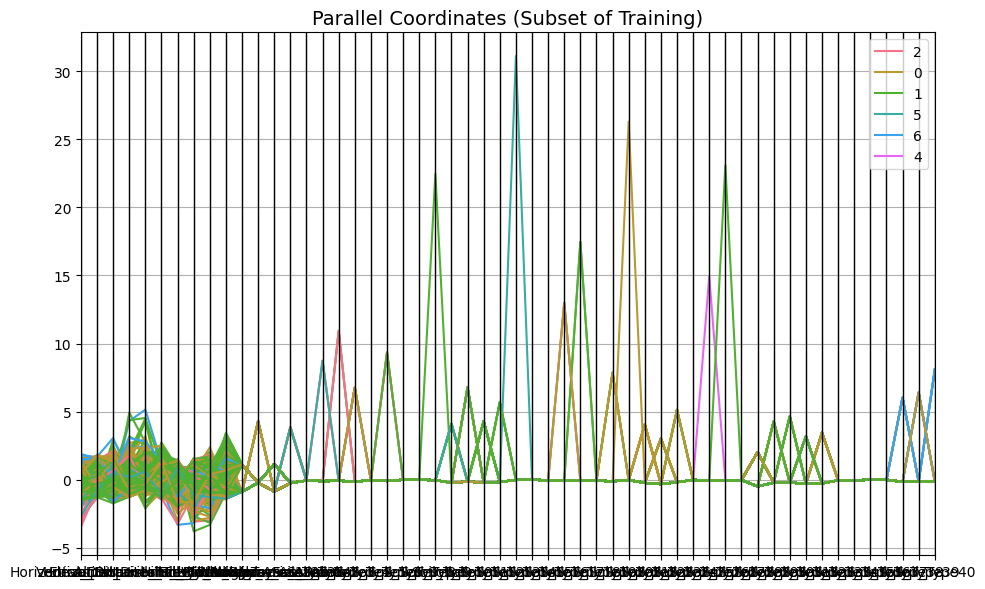

In [ ]:
# -----------------------------------------------------------------------------
# 6. Visualization: Parallel Coordinates for multi-class
# -----------------------------------------------------------------------------
# We'll randomly sample a smaller portion of the training set for a parallel coords plot
# to keep it readable
from pandas.plotting import parallel_coordinates

sample_size = 300
idx_subset = np.random.choice(X_train.index, sample_size, replace=False)
df_plot = X_train.loc[idx_subset].copy()
df_plot[target] = y_train.loc[idx_subset]

# For parallel_coordinates, rename target to 'class' and ensure it's str
df_plot['class'] = df_plot[target].astype(str)
df_plot.drop(target, axis=1, inplace=True)

plt.figure(figsize=(10,6))
parallel_coordinates(df_plot, class_column='class', cols=df_plot.columns[:-1], color=sns.color_palette("husl", df_plot['class'].nunique()))
plt.title("Parallel Coordinates (Subset of Training)", fontsize=14)
plt.tight_layout()
plt.show()

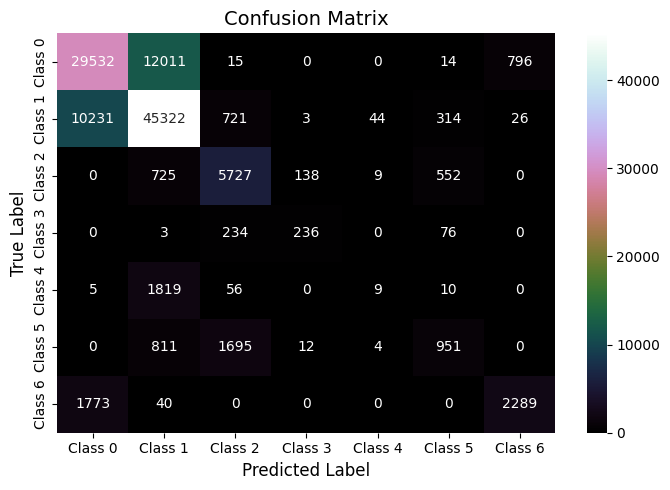

In [ ]:
# -----------------------------------------------------------------------------
# 7. Visualization: Confusion Matrix (cubehelix colormap)
# -----------------------------------------------------------------------------
plt.figure(figsize=(7,5))
sns.heatmap(cm, annot=True, fmt='d', cmap="cubehelix",
            xticklabels=[f"Class {i}" for i in range(y.nunique())],
            yticklabels=[f"Class {i}" for i in range(y.nunique())])
plt.xlabel("Predicted Label", fontsize=12)
plt.ylabel("True Label", fontsize=12)
plt.title("Confusion Matrix", fontsize=14)
plt.tight_layout()
plt.show()

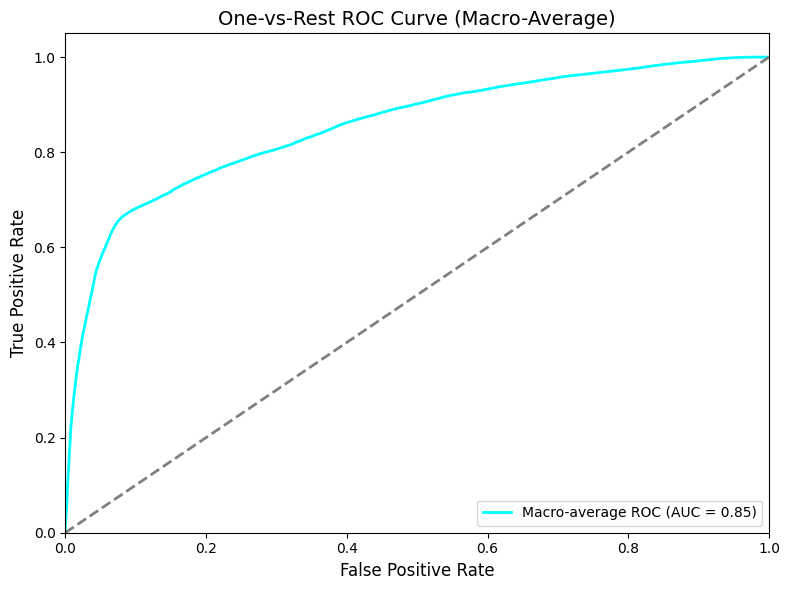

In [ ]:
# -----------------------------------------------------------------------------
# 8. Visualization: One-vs-Rest ROC (macro-average)
# -----------------------------------------------------------------------------
# Binarize labels for multi-class ROC
n_classes = y.nunique()
y_test_bin = label_binarize(y_test, classes=range(n_classes))

# We need predicted decision_function or probability
y_score = log_reg.decision_function(X_test)

# Compute ROC curve and AUC for each class, then macro-average
fpr_dict, tpr_dict, roc_auc_dict = {}, {}, {}
for i in range(n_classes):
    fpr_dict[i], tpr_dict[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc_dict[i] = auc(fpr_dict[i], tpr_dict[i])

# Compute macro-average
all_fpr = np.unique(np.concatenate([fpr_dict[i] for i in range(n_classes)]))
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += np.interp(all_fpr, fpr_dict[i], tpr_dict[i])
mean_tpr /= n_classes
macro_roc_auc = auc(all_fpr, mean_tpr)

plt.figure(figsize=(8,6))
plt.plot(all_fpr, mean_tpr, color='cyan', lw=2, label=f"Macro-average ROC (AUC = {macro_roc_auc:.2f})")
plt.plot([0,1],[0,1], color='gray', lw=2, linestyle='--')
plt.xlim([0,1])
plt.ylim([0,1.05])
plt.xlabel("False Positive Rate", fontsize=12)
plt.ylabel("True Positive Rate", fontsize=12)
plt.title("One-vs-Rest ROC Curve (Macro-Average)", fontsize=14)
plt.legend(loc="lower right", fontsize=10)
plt.tight_layout()
plt.show()

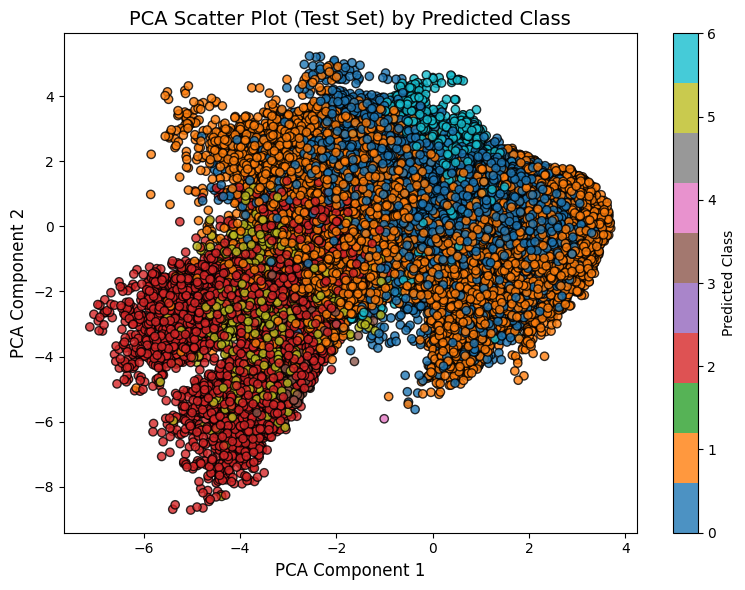

In [ ]:
# -----------------------------------------------------------------------------
# 9. Visualization: PCA-based 2D Scatter of Test Data
# -----------------------------------------------------------------------------
pca = PCA(n_components=2, random_state=42)
X_test_pca = pca.fit_transform(X_test)

plt.figure(figsize=(8,6))
scatter = plt.scatter(X_test_pca[:,0], X_test_pca[:,1], c=y_pred, cmap='tab10', alpha=0.8, edgecolor='k')
plt.colorbar(scatter, label="Predicted Class")
plt.xlabel("PCA Component 1", fontsize=12)
plt.ylabel("PCA Component 2", fontsize=12)
plt.title("PCA Scatter Plot (Test Set) by Predicted Class", fontsize=14)
plt.tight_layout()
plt.show()

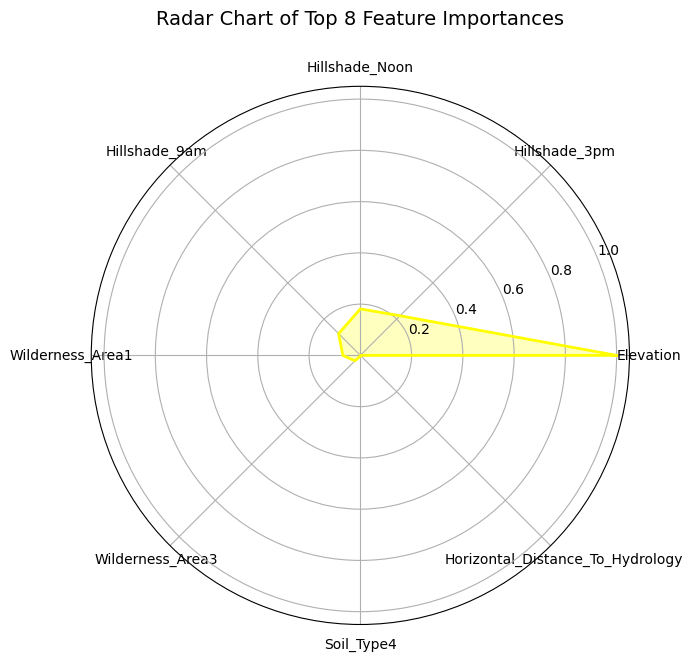

In [ ]:
# -----------------------------------------------------------------------------
# 10. Visualization: Radar Chart for Permutation Feature Importance
# -----------------------------------------------------------------------------
perm_import = permutation_importance(log_reg, X_test, y_test, n_repeats=5, random_state=42, scoring='accuracy')
importances = perm_import.importances_mean
sorted_idx = np.argsort(importances)[::-1]
top_n = 8
top_idx = sorted_idx[:top_n]
top_features = X_train.columns[top_idx]
top_values = importances[top_idx]

# Normalize importances to [0,1]
norm_vals = (top_values - top_values.min()) / (top_values.max() - top_values.min())

# Create angles for each feature in a radar chart
angles = np.linspace(0, 2*np.pi, top_n, endpoint=False).tolist()
angles += angles[:1]  # close the circle
norm_vals = np.concatenate((norm_vals, [norm_vals[0]]))

fig = plt.figure(figsize=(7,7))
ax = fig.add_subplot(111, polar=True)
ax.plot(angles, norm_vals, color='yellow', linewidth=2)
ax.fill(angles, norm_vals, color='yellow', alpha=0.25)
ax.set_thetagrids(np.degrees(angles[:-1]), labels=top_features)
ax.set_title("Radar Chart of Top 8 Feature Importances", fontsize=14, y=1.10)
plt.tight_layout()
plt.show()